In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import data_utils
import h5py
import numpy as np

hdf_idx = 12
np.set_printoptions(threshold=10_000)
with h5py.File("data/lakh_played_notes.h5", "r") as file:
    seq_len = file["seq_lens"][hdf_idx]
    start_idx = sum(file["seq_lens"][:hdf_idx])
    played_notes = file["played_notes"][start_idx:start_idx + seq_len]
    print(played_notes.shape)
    # print(played_notes)
    # played_notes[played_notes == -1] = played_notes.max() + 1 
    print(played_notes.max(axis=1))

(1084, 5)
[ 7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7 17 17 17 17 17 17
 17 17 17 17 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 12 12 12 12 12 12 12 12 12 12 12 1

In [12]:
import matplotlib.pyplot as plt

from dataset import get_data_loaders_for_training
from data_utils import HDF_FILE_PATH

batch_size = 1
num_workers = 1

_, devtrain_loader, dev_loader = get_data_loaders_for_training(HDF_FILE_PATH, batch_size, num_workers)

/mnt/projects/2025_16_01_midi_exps/data_utils.py:404: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  plt.figure(figsize=(12, 6))


Loss:  tensor(0.0262, device='cuda:0')
Loss:  tensor(0.0285, device='cuda:0')
Loss:  tensor(0.0500, device='cuda:0')
Loss:  tensor(0.0197, device='cuda:0')
Loss:  tensor(0.0309, device='cuda:0')
Loss:  tensor(0.0483, device='cuda:0')
Loss:  tensor(0.0505, device='cuda:0')


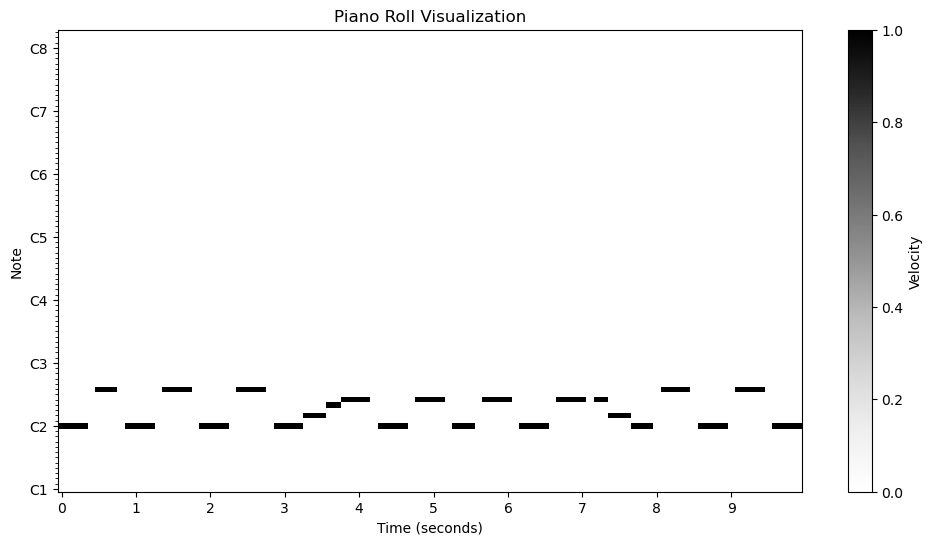

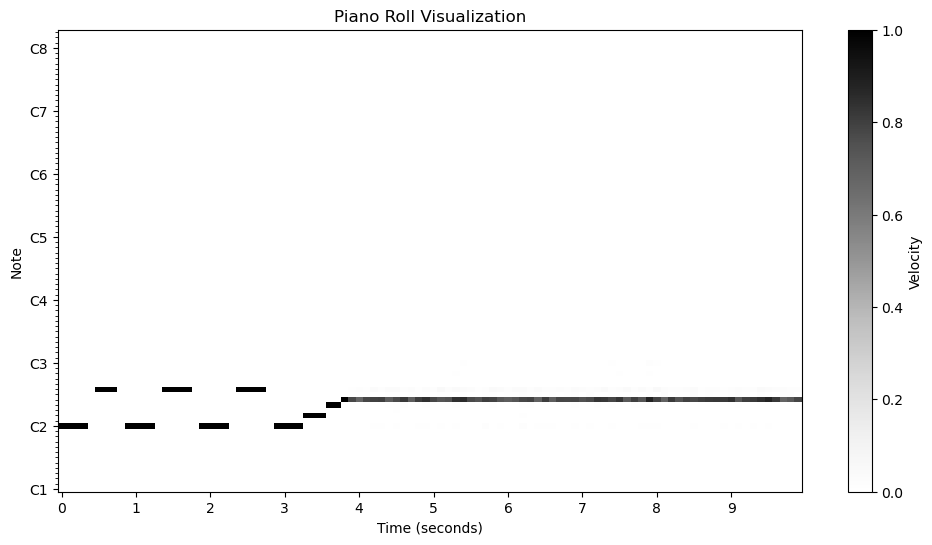

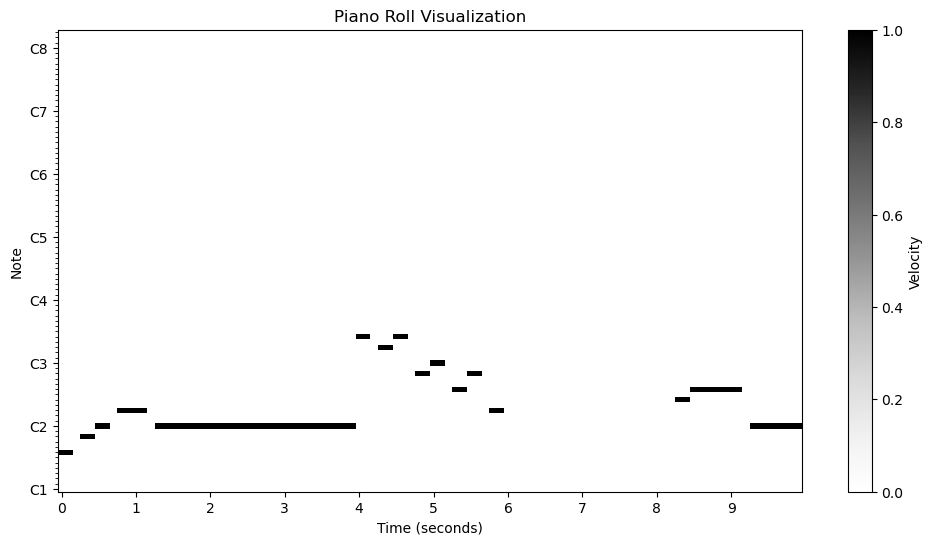

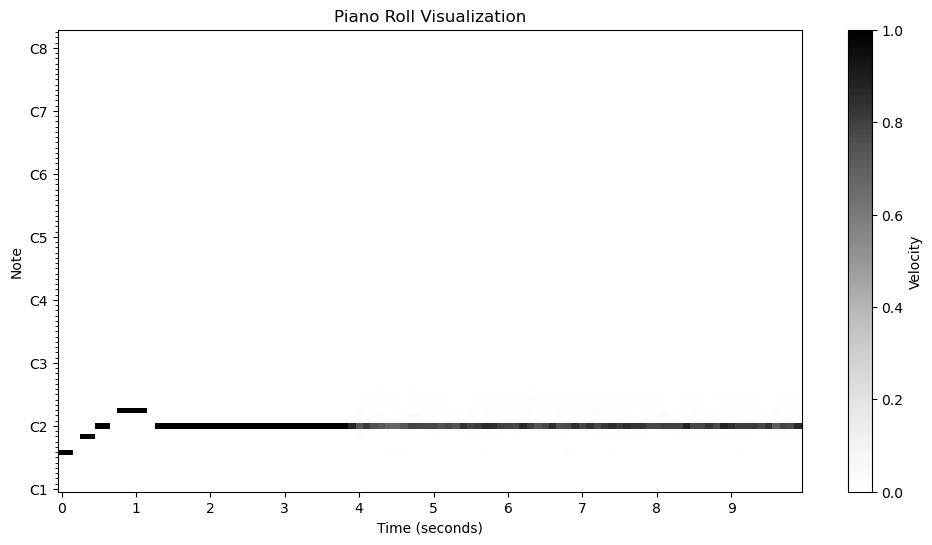

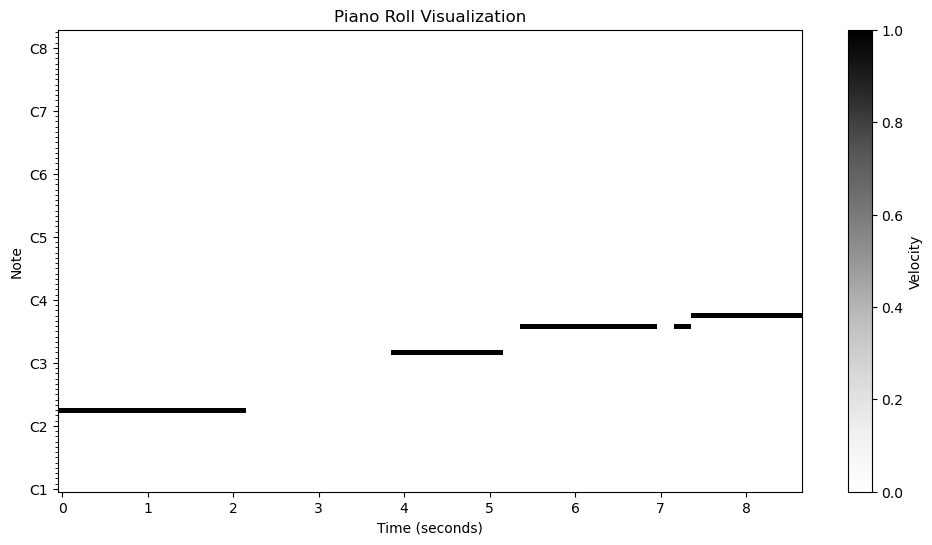

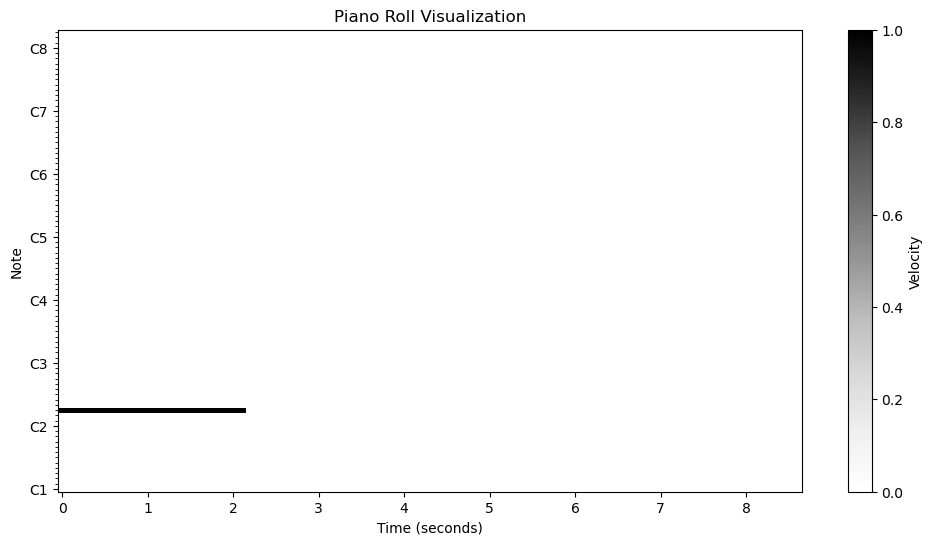

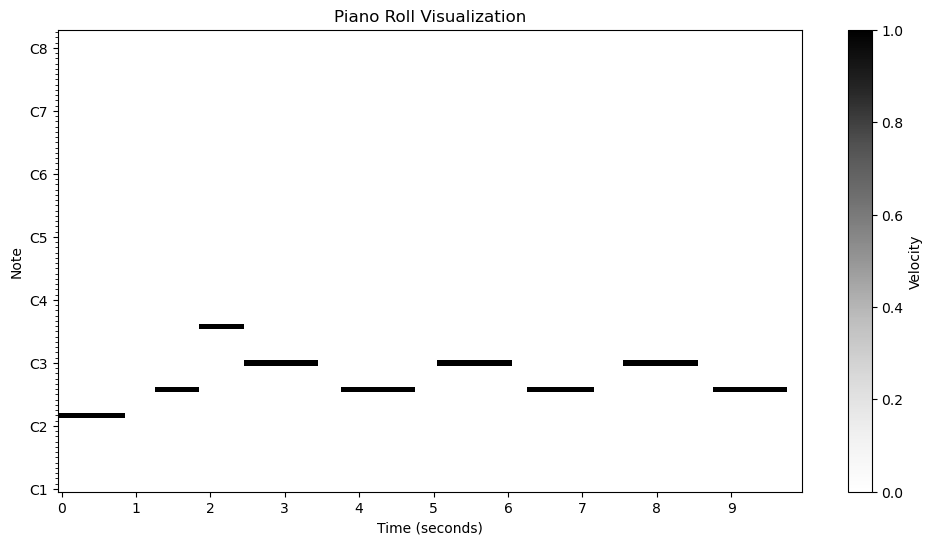

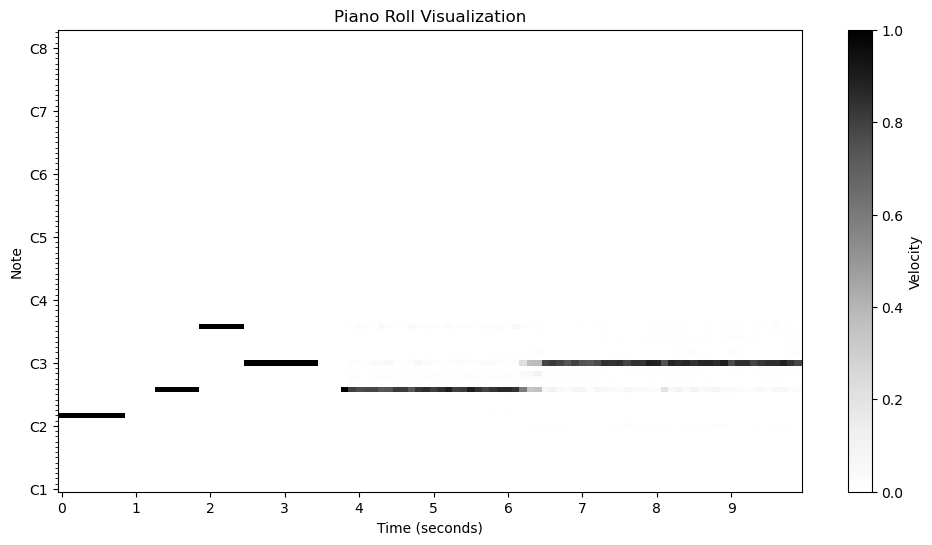

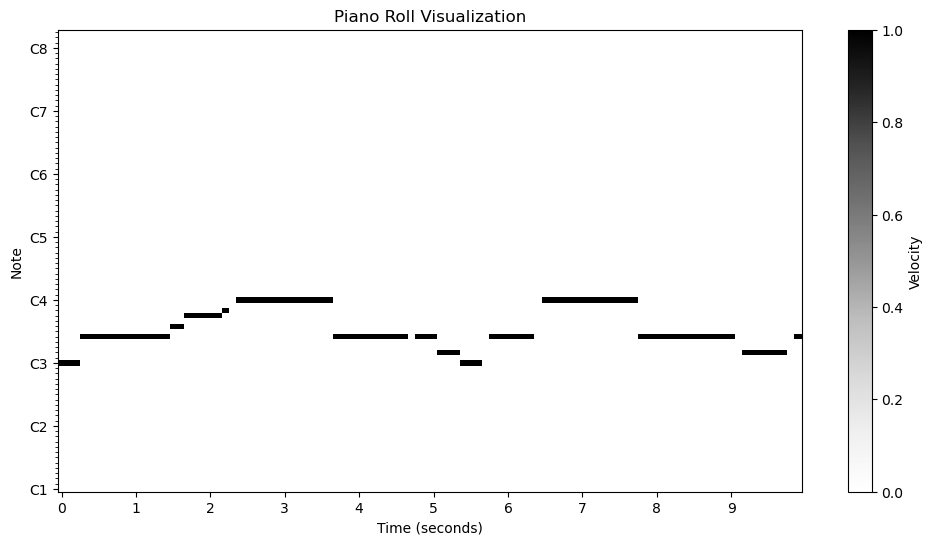

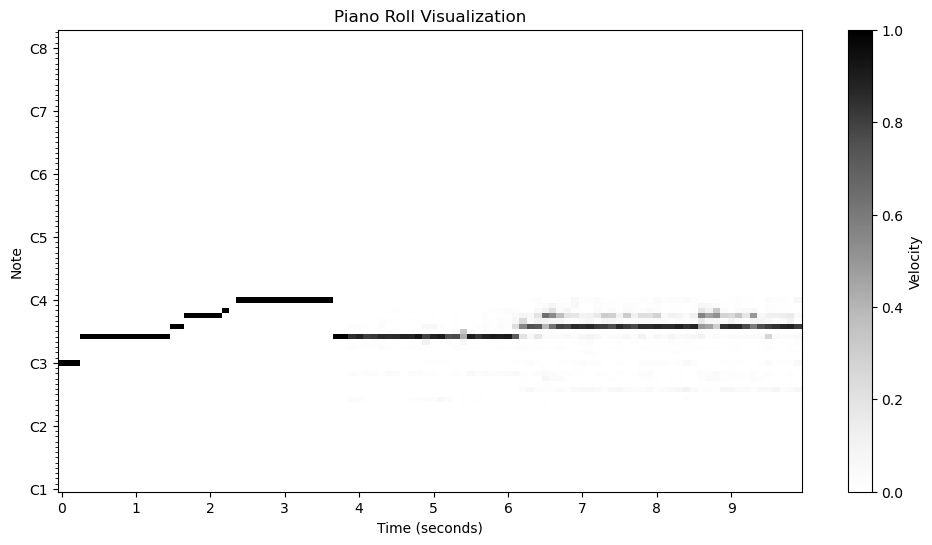

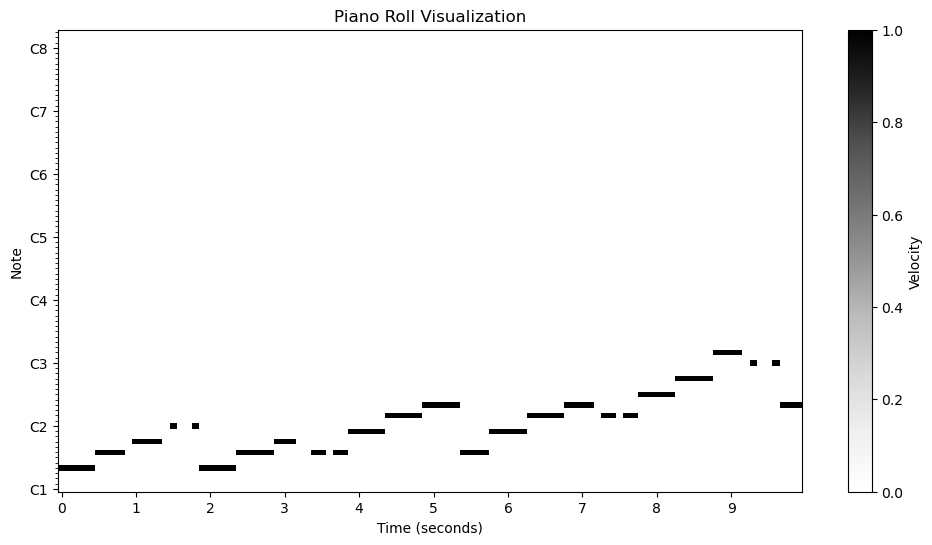

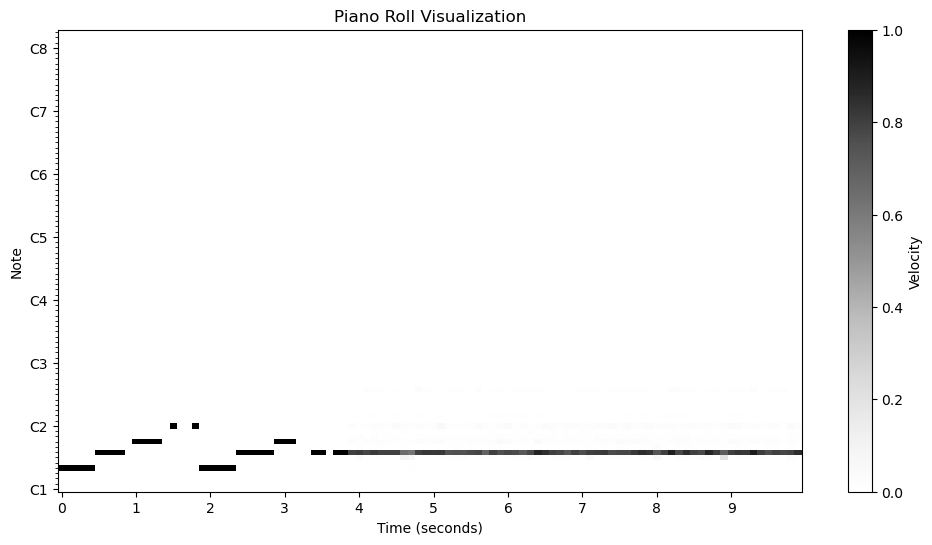

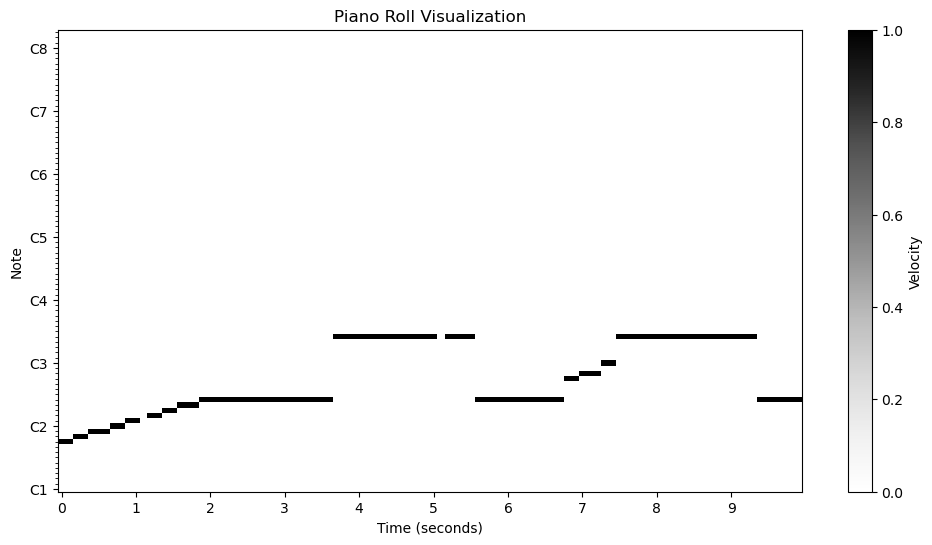

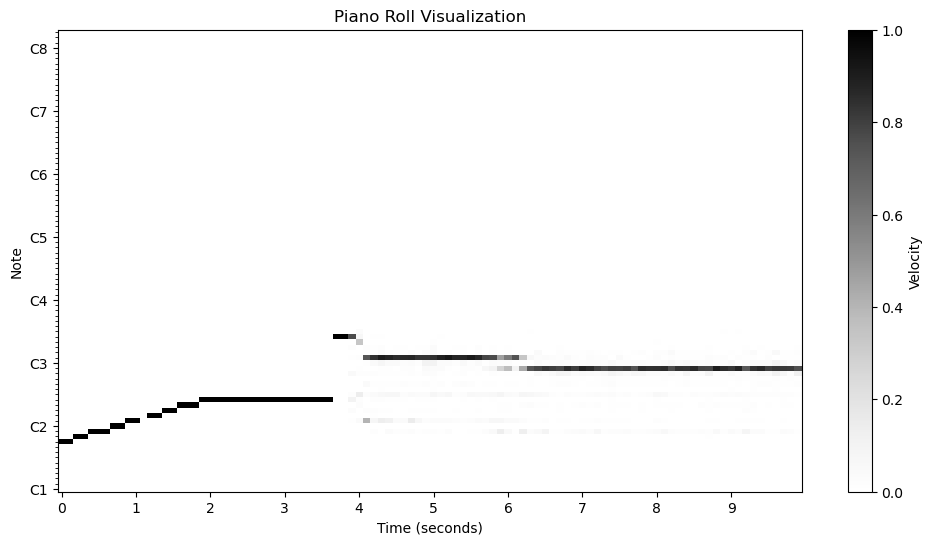

In [13]:
from data_utils import visualize_piano_roll
from models.transformer import TransformerDecoderModel, MODEL_CHECKPOINTS_PATH
from models.configs import transformer_v1_config
from torch import nn
import torch.nn.functional as F
import torch

N_CONTEXT_FRAMES = 40
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerDecoderModel(**transformer_v1_config["model_opts"])
model_name = "transformer_v1_lr-1e-3_bce_10-epochs_batch-size-256"
model.load_state_dict(torch.load(f"{MODEL_CHECKPOINTS_PATH}/{model_name}.pt"), strict=False)
model.to(DEVICE)
criterion = nn.BCELoss()

def piano_rolls_tensor_to_numpy(piano_rolls_tensor: torch.Tensor):
  return piano_rolls_tensor.permute(1, 2, 0)[0].cpu().numpy()


for batch_idx, (piano_rolls, _) in enumerate(dev_loader):
  piano_rolls = piano_rolls.to(DEVICE).transpose(0, 1)  # [seq_len, batch_size, input_dim]
  piano_rolls_shifted = F.pad(piano_rolls, (0, 0, 0, 0, 1, 0))[:-1]  # [seq_len, batch_size, input_dim]

  visualize_piano_roll(
      piano_rolls_tensor_to_numpy(piano_rolls),
  )

  with torch.no_grad():
    n_prediction_steps = piano_rolls.size(0) - N_CONTEXT_FRAMES
    # context frames to start prediction
    piano_rolls_context = piano_rolls_shifted[:N_CONTEXT_FRAMES].to(DEVICE)
    # create tensor to hold the predicted tensor
    predicted_piano_rolls = torch.zeros(
      (piano_rolls.size(0) + 1, *piano_rolls.size()[1:]),
      device=DEVICE
    )
    # insert context into tensor while considering initial 0 padding frame
    predicted_piano_rolls[:N_CONTEXT_FRAMES] = piano_rolls_context

    for step in range(n_prediction_steps + 1):
      logits = model(predicted_piano_rolls[:N_CONTEXT_FRAMES + step])
      outputs = torch.sigmoid(logits)
      # outputs[outputs >= 0.5] = 1
      # outputs[outputs < 0.5] = 0
      predicted_piano_rolls[N_CONTEXT_FRAMES + step] = outputs[-1]
      
    predicted_piano_rolls = predicted_piano_rolls[1:]  # remove initial 0 padding frame

  visualize_piano_roll(
      piano_rolls_tensor_to_numpy(predicted_piano_rolls),
  )

  loss = criterion(predicted_piano_rolls, piano_rolls)  # Example target as input
  print("Loss: ", loss)

  if batch_idx > 5:
    break